In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
pd.options.mode.chained_assignment = None

In [2]:
#Lettura dei file csv
dfm = pd.read_csv('csv/D_moisture.txt')
dfv = pd.read_csv('csv/D_valve.txt')

#Formattazione corretta dei dati
dfm["time_stamp"] = pd.to_datetime(dfm["time_stamp"], format='%d-%b-%Y %H:%M:%S')
dfv["time_stamp"] = pd.to_datetime(dfv["time_stamp"], format='%d-%b-%Y %H:%M:%S')

In [3]:
#Funzione per determinare se la valvola è stata aperta o meno
def is_open(A, B):
    '''
    Given A and B integer values (0 or 1), this function follows the following logic table:
    A | B | is_open
    0 | 0 | 0
    0 | 1 | 1
    1 | 0 | 0
    1 | 1 | 1
    '''
    return int((A and B) or (not A and B))

In [4]:
#Allinea i dati in base al tempo
dfm["open"] = None
idx = 0
open = 0

for i in range(idx, len(dfm)-1):
    #Definizione dei lower e upper bounds
    lb = dfm.loc[i]["time_stamp"]
    ub = dfm.loc[i+1]["time_stamp"]
    
    for j in range(idx, len(dfv)):
        tv = dfv.loc[j]["time_stamp"]        
        if lb <= tv <= ub:
            value = dfv.loc[dfv["time_stamp"] == tv, "relay"].values[0]
            open = is_open(open, value)
        elif tv < lb:
            continue
        else:
            idx = j
            dfm.loc[dfm["time_stamp"] == lb, "open"] = open
            break

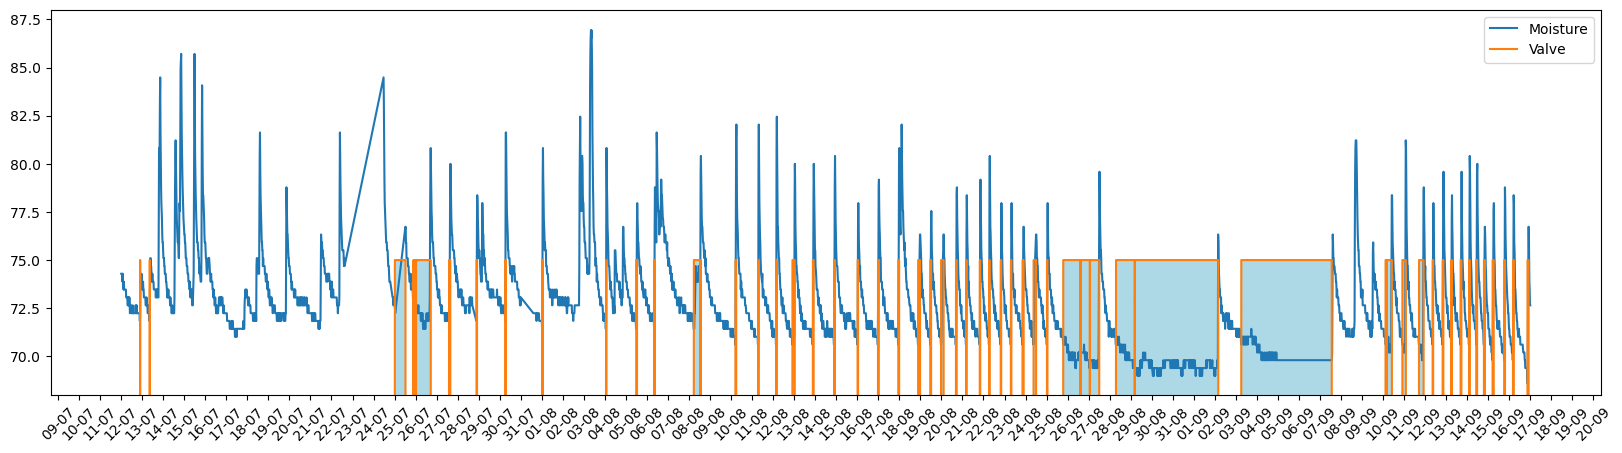

In [14]:
#Raffigurazione dei dati del valve e del tempo
plt.figure(figsize=(20, 5))
plt.plot(dfm["time_stamp"], dfm["moisture"])
ax = plt.plot(dfv["time_stamp"], dfv["relay"]*75)
x = dfv["time_stamp"]
y = dfv["relay"]*75
plt.fill_between(x, y, where=y<76, color='lightblue')
plt.ylim(68,88)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.legend(["Moisture", "Valve"])
plt.show()

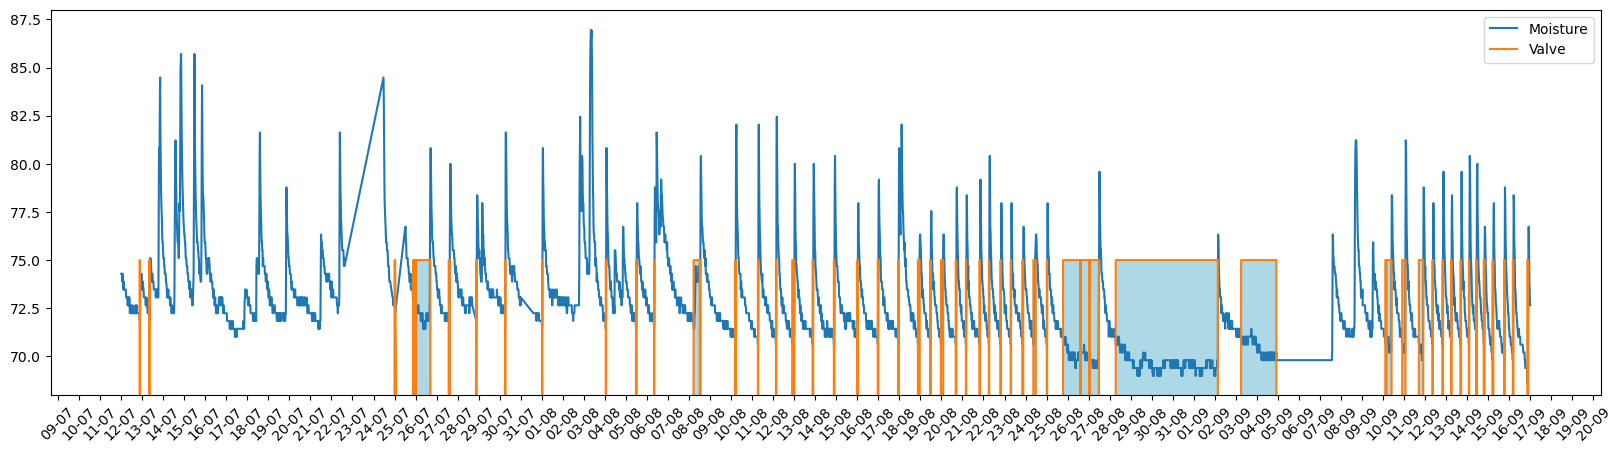

In [16]:
#Raffigurazione dei dati del moisture e del tempo
plt.figure(figsize=(20, 5))
plt.plot(dfm["time_stamp"], dfm["moisture"])
ax = plt.plot(dfm["time_stamp"], dfm["open"]*75)
x = dfm["time_stamp"]
y = (dfm["open"]*75).fillna(0)
plt.fill_between(x, y, where=y<76, color='lightblue')
plt.ylim(68,88)
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.xticks(rotation=45)
plt.legend(["Moisture", "Valve"])
plt.show()

# Train ML

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

X = dfm[["moisture"]]
# Riempire i valori nan
X.ffill(inplace=True)
y = dfm["open"]
y.fillna(0, inplace=True)

# Normalizzare i valori
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9254947613504074
Confusion Matrix:
[[676  16]
 [ 48 119]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       692
           1       0.88      0.71      0.79       167

    accuracy                           0.93       859
   macro avg       0.91      0.84      0.87       859
weighted avg       0.92      0.93      0.92       859



"Alta accuratezza, ma basso richiamo per l'etichetta '1' (aperta). Ciò significa che la valvola non viene predetta aperta quando dovrebbe esserlo."

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion}")
print(f"Classification Report:\n{report}")

Accuracy: 0.7951105937136205
Confusion Matrix:
[[542 150]
 [ 26 141]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       692
           1       0.48      0.84      0.62       167

    accuracy                           0.80       859
   macro avg       0.72      0.81      0.74       859
weighted avg       0.86      0.80      0.81       859



"Precisione più bassa, ma richiamo più elevato. Più falsi positivi, il che significa che la valvola è stata aperta inutilmente."

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
model = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=None,           # Maximum depth of the tree (None allows trees to grow fully)
    class_weight="balanced",  # Handles class imbalance
    random_state=42           # For reproducibility
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion}")
print(f"Classification Report:\n{report}")

Accuracy: 0.889406286379511
Confusion Matrix:
[[627  65]
 [ 30 137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       692
           1       0.68      0.82      0.74       167

    accuracy                           0.89       859
   macro avg       0.82      0.86      0.84       859
weighted avg       0.90      0.89      0.89       859



"Buon compromesso tra precisione e richiamo."

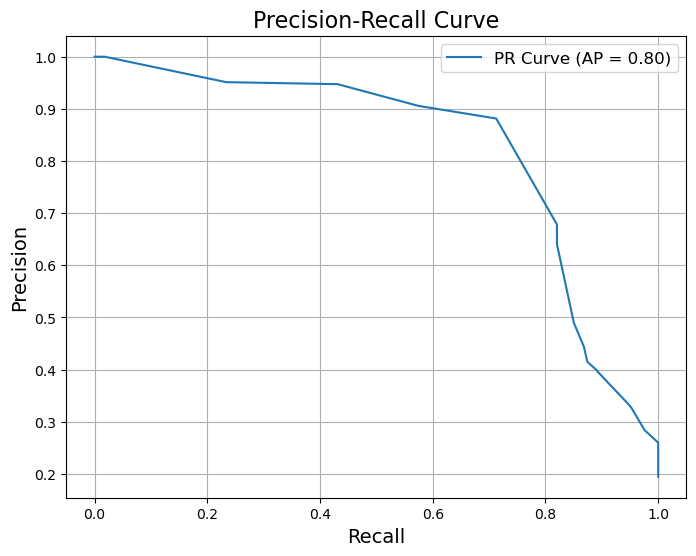

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid()
plt.show()

In [61]:
y_thr = (y_probs > 0.3).astype(int)
accuracy = accuracy_score(y_test, y_thr)
confusion = confusion_matrix(y_test, y_thr)
report = classification_report(y_test, y_thr)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{confusion}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8754365541327125
Confusion Matrix:
[[615  77]
 [ 30 137]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       692
           1       0.64      0.82      0.72       167

    accuracy                           0.88       859
   macro avg       0.80      0.85      0.82       859
weighted avg       0.89      0.88      0.88       859



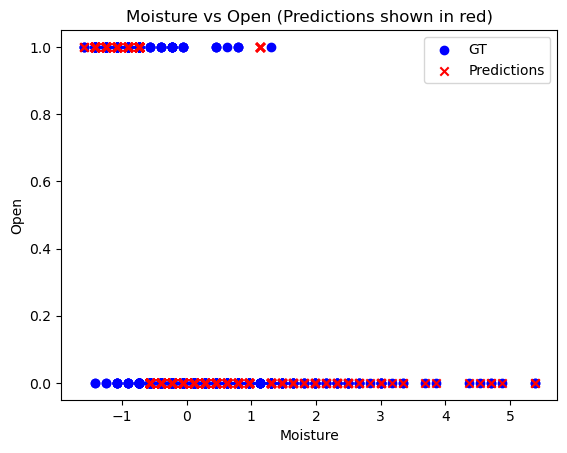

In [62]:
import matplotlib.pyplot as plt
plt.scatter(X_test, y_test, color='blue', label='GT')
plt.scatter(X_test, y_thr, color='red', label='Predictions', marker='x')
plt.xlabel('Moisture')
plt.ylabel('Open')
plt.title('Moisture vs Open (Predictions shown in red)')
plt.legend()
plt.show()

## Save model

In [12]:
# Salvare il modello di sklearn
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']